<a href="https://colab.research.google.com/github/radanim/HM-AIRS-PROGRAM/blob/master/%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EC%84%9D%26%EB%A7%88%EC%8A%A4%ED%82%B9(segmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os
import json

In [44]:
pwd

'/content'

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
json_data=open("/content/drive/MyDrive/미래와도전_시계열/fashion_img/label_descriptions.json").read()
label_descriptions = json.loads(json_data)
# 공유 드라이브 폴더를 내 드라이브에 바로가기 추가하여 경로 재설정. 그냥 드라이브에서는 공유드라이브 폴더 인식 못해줌. 
# dataset info
label_descriptions['info']

{'year': 2019,
 'version': '1.0',
 'description': 'The 2019 FGVC^6 iMaterialist Competition - Fashion track dataset.',
 'contributor': 'iMaterialist Fashion Competition group',
 'url': 'https://github.com/visipedia/imat_comp',
 'date_created': '2019-04-19 12:38:27.493919'}

In [47]:
# dataset categories
# 데이터셋에서 아이템별로 id를 부여, 상위 카테고리도 별도로 지정하여 표시 
categories_label_df = pd.DataFrame(label_descriptions['categories'])
print("The number of categories : ",len(categories_label_df))
display(categories_label_df)

The number of categories :  46


,id,name,supercategory,level
0,0,"shirt, blouse",upperbody,2
1,1,"top, t-shirt, sweatshirt",upperbody,2
2,2,sweater,upperbody,2
3,3,cardigan,upperbody,2
4,4,jacket,upperbody,2
5,5,vest,upperbody,2
6,6,pants,lowerbody,2
7,7,shorts,lowerbody,2
8,8,skirt,lowerbody,2
9,9,coat,wholebody,2


In [48]:
# supercategory class
categories_label_df.groupby('supercategory')['name'].count()

supercategory
arms and hands     2
closures           2
decorations       10
garment parts      7
head               3
legs and feet      4
lowerbody          3
neck               1
others             3
upperbody          6
waist              1
wholebody          4
Name: name, dtype: int64

In [49]:
# dataset attributes
attributes_label_df = pd.DataFrame(label_descriptions['attributes'])
print("The number of attributes : ",len(attributes_label_df))
display(attributes_label_df.head())

The number of attributes :  92


,id,name,supercategory,level
0,0,above-the-hip (length),length,1
1,1,hip (length),length,1
2,2,micro (length),length,1
3,3,mini (length),length,1
4,4,above-the-knee (length),length,1


## Load Train Data

In [50]:
train_df = pd.read_csv("/content/drive/MyDrive/미래와도전_시계열/fashion_img/train.csv")
print(train_df.shape)
print("number of unique images :",len(set(train_df['ImageId'])))
train_df.head(5)

(331213, 5)
number of unique images : 45195


,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


In [51]:
# split classid to category & attributes ..
def split_ClassId(data):
    
    data_c = data.copy()

    class_list = []
    attribute_list = []

    for i in range(len(data_c)):
        classid = data_c.iloc[i,4]

        # IF attribute exists, 
        if len(classid) > 2:
            class_attribute_list = classid.split("_")

            class_list.append(class_attribute_list[0])
            attribute_list.append(class_attribute_list[1:])

        else:
            class_list.append(classid)
            attribute_list.append("")

    data_c["class_"] = class_list
    data_c["attributes"] = attribute_list
    
    return data_c

In [52]:
# split classid to category & attributes
train_df['Category'] = train_df['ClassId'].apply(lambda x: int(x.split("_")[0]))
train_df['Attributes'] = train_df['ClassId'].apply(lambda x: list(map(int, x.split("_")[1:])))
train_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId,Category,Attributes
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6,[]
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0,[]
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28,[]
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31,[]
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32,[]


## EDA

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


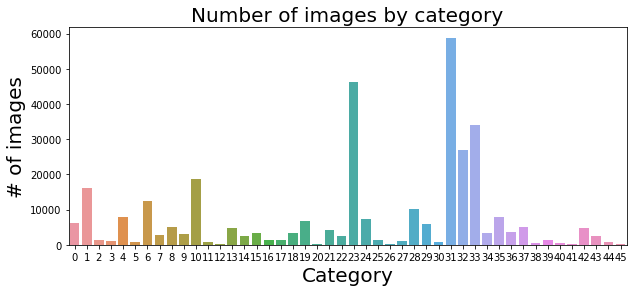

In [53]:
groupby_category = train_df.groupby('Category')['ImageId'].count()
groupby_category.index = map(int, groupby_category.index)
groupby_category = groupby_category.sort_index()
groupby_category[:5]

fig = plt.figure(figsize=(10, 4))
x = groupby_category.index
y = groupby_category.values

sns.barplot(x,y)
plt.title("Number of images by category", fontsize=20)
plt.xlabel("Category", fontsize=20)
plt.ylabel("# of images", fontsize=20)
plt.show()

In [54]:
groupby_category = train_df[['ImageId','Category']].groupby('ImageId').count()
print("Average number of categories per unique image: ",np.mean(groupby_category['Category'][::]))

Average number of categories per unique image:  7.328531917247483


### categories w and w/o attributes

In [55]:
train_Having_attributes_df = train_df[train_df['Attributes'].apply(len) > 0]
print("the number of images having attributes:",len(train_Having_attributes_df['ImageId']))
print("the number of unique images having attributes:",len(set(train_Having_attributes_df['ImageId'])))
#print("---------------------------------------------")

the number of images having attributes: 11499
the number of unique images having attributes: 6672


In [56]:
# The Number of images with Attributes by Category
groupby_category_Having_attributes = train_Having_attributes_df[['ImageId','Category']].groupby('Category').count()
groupby_category_Having_attributes.columns = ['# of imgs']
display(groupby_category_Having_attributes)

,# of imgs
Category,
0,593
1,2505
2,123
3,118
4,1032
5,91
6,1718
7,514
8,1007


In [57]:
Having_attributes = list(groupby_category_Having_attributes.index)
print("categories having attributes are: \n", Having_attributes)
print()
print("categories not having attributes are: \n", list(categories_label_df.id[~categories_label_df.id.isin(Having_attributes)]))

categories having attributes are: 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 27, 28, 33]

categories not having attributes are: 
 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]


In [58]:
group_category_df = train_Having_attributes_df[["Category","Attributes"]].groupby(by = "Category").sum().reset_index()
group_category_df = pd.merge(group_category_df,categories_label_df,left_on = 'Category',right_on='id')

# kind of Attributes per category
group_category_df

,Category,Attributes,id,name,supercategory,level
0,0,"[1, 20, 41, 60, 69, 88, 10, 20, 42, 50, 61, 87...",0,"shirt, blouse",upperbody,2
1,1,"[1, 20, 41, 49, 61, 91, 20, 41, 60, 61, 91, 1,...",1,"top, t-shirt, sweatshirt",upperbody,2
2,2,"[1, 20, 42, 60, 62, 91, 1, 20, 42, 60, 61, 91,...",2,sweater,upperbody,2
3,3,"[1, 10, 20, 41, 60, 61, 91, 1, 10, 20, 41, 60,...",3,cardigan,upperbody,2
4,4,"[0, 20, 41, 60, 72, 88, 41, 61, 0, 10, 20, 40,...",4,jacket,upperbody,2
5,5,"[0, 14, 20, 41, 46, 61, 91, 18, 20, 40, 45, 49...",5,vest,upperbody,2
6,6,"[8, 20, 39, 60, 70, 8, 14, 20, 37, 42, 60, 61,...",6,pants,lowerbody,2
7,7,"[2, 15, 20, 41, 48, 61, 88, 2, 15, 20, 41, 46,...",7,shorts,lowerbody,2
8,8,"[3, 14, 20, 33, 60, 61, 88, 3, 10, 19, 25, 53,...",8,skirt,lowerbody,2
9,9,"[3, 20, 42, 59, 61, 91, 4, 13, 20, 40, 60, 70,...",9,coat,wholebody,2


In [59]:
# the distribution of # of attributes per images, among images with attributes
train_Having_attributes_desc = train_Having_attributes_df.iloc[:,6].apply(len).describe()
train_Having_attributes_desc

count    11499.000000
mean         6.215062
std          1.175101
min          1.000000
25%          6.000000
50%          6.000000
75%          7.000000
max         10.000000
Name: Attributes, dtype: float64

## Unique Image EDA

,ImageId,Num_of_ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,9
1,0000fe7c9191fba733c8a69cfaf962b7.jpg,2
2,0002ec21ddb8477e98b2cbb87ea2e269.jpg,4


       Num_of_ClassId
count    45195.000000
mean         7.328532
std          3.904183
min          1.000000
50%          7.000000
55%          7.000000
60%          8.000000
65%          8.000000
70%          9.000000
75%         10.000000
80%         10.000000
85%         11.000000
90%         13.000000
95%         15.000000
max         74.000000


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


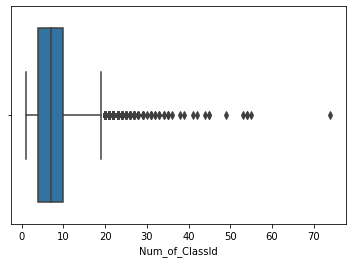

In [60]:
# The number of ClassId(Category) per unique Image
group_unique_df = train_df[["ImageId", "Height"]].groupby(by = "ImageId").count().reset_index()
group_unique_df.columns = ['ImageId', 'Num_of_ClassId']
display(group_unique_df.head(3))
sns.boxplot(group_unique_df['Num_of_ClassId'])
print(group_unique_df.describe(percentiles = np.arange(0.5, 1.0, 0.05)))

In [61]:
class_over20_data_df = group_unique_df[group_unique_df['Num_of_ClassId'] > 20]
print(class_over20_data_df.head())
print(class_over20_data_df.shape)

                                  ImageId  Num_of_ClassId
248  01693d0a97629f06afb4fc8f3228a7e6.jpg              22
416  0256533b25e94fd01194bd78649296b7.jpg              33
463  029720c77ebda81f6a57efd7a34df406.jpg              28
508  02d5bed7de4f4f5567add26f50ecc8d0.jpg              25
700  03ebb3b4c195415126834c89f8da55b5.jpg              22
(196, 2)


In [62]:
group_unique_df[group_unique_df['Num_of_ClassId']==74]
train_df[train_df.ImageId=='361cc7654672860b1b7c85fe8e92b38a.jpg'].drop_duplicates('ClassId')

,ImageId,EncodedPixels,Height,Width,ClassId,Category,Attributes
70042,361cc7654672860b1b7c85fe8e92b38a.jpg,1486091 12 1488330 30 1490577 40 1492824 50 14...,2250,1500,6,6,[]
70043,361cc7654672860b1b7c85fe8e92b38a.jpg,1898640 6 1900883 17 1903120 35 1903169 14 190...,2250,1500,23,23,[]
70045,361cc7654672860b1b7c85fe8e92b38a.jpg,1220607 3 1222852 8 1224993 14 1225097 13 1227...,2250,1500,31,31,[]
70047,361cc7654672860b1b7c85fe8e92b38a.jpg,1220607 3 1222852 8 1224993 14 1225097 13 1227...,2250,1500,4,4,[]
70048,361cc7654672860b1b7c85fe8e92b38a.jpg,1758192 8 1760427 23 1762665 35 1764906 44 176...,2250,1500,1,1,[]
70049,361cc7654672860b1b7c85fe8e92b38a.jpg,1434185 4 1436427 12 1438669 21 1440911 29 144...,2250,1500,35,35,[]
70050,361cc7654672860b1b7c85fe8e92b38a.jpg,2189993 2 2192239 6 2194485 11 2196732 14 2198...,2250,1500,32,32,[]
70055,361cc7654672860b1b7c85fe8e92b38a.jpg,1683443 3 1685691 9 1687939 16 1690187 22 1692...,2250,1500,28,28,[]
70057,361cc7654672860b1b7c85fe8e92b38a.jpg,2034399 2 2036647 5 2038896 7 2041145 7 204339...,2250,1500,42,42,[]
70115,361cc7654672860b1b7c85fe8e92b38a.jpg,1807238 1 1809489 1 1811739 2 1813989 3 181623...,2250,1500,33,33,[]


## EDA on Image

In [63]:
def show_img(IMG_FILE):
    I = cv2.imread("/content/drive/MyDrive/미래와도전_시계열/fashion_img/train/" + IMG_FILE, cv2.IMREAD_COLOR)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    plt.imshow(I) 
    plt.tight_layout()
    plt.show()

make sample data
- Category : 0, 4, 6, 28, 29, 31, 32
- no Attributes
- ImageId == '00000663ed1ff0c4e0132b9b9ac53f6e.jpg'

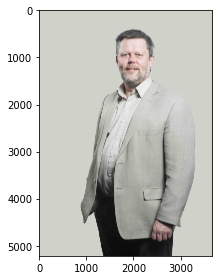

In [42]:
show_img('00000663ed1ff0c4e0132b9b9ac53f6e.jpg')

In [64]:
def make_mask(IMG_FILE):
    df = train_df[train_df.ImageId == IMG_FILE].reset_index(drop = True)
    H = df.iloc[0,2]
    W = df.iloc[0,3]
    
    print("Correct Category :", sorted(set((list(df.Category)))))
    # 1d mask 
    mask = np.full(H*W,dtype='int',fill_value = -1)
    
    for line in df[['EncodedPixels','Category']].iterrows():
        EncodedPixels = line[1][0]
        Category = line[1][1]
        
        pixel_loc = list(map(int,EncodedPixels.split(' ')[0::2]))
        iter_num =  list(map(int,EncodedPixels.split(' ')[1::2]))
        for p,i in zip(pixel_loc,iter_num):
            mask[p:(p+i)] = Category
    
    print("Output :",sorted(set(list(mask))))
    #rle
    mask = mask.reshape(W,H).T
    
    return mask

Correct Category : [0, 4, 6, 28, 29, 31, 32]
Output : [-1, 0, 4, 6, 28, 29, 31]


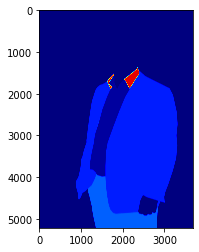

In [65]:
# Category : 0, 4, 6, 28, 29, 31, 32
mask = make_mask('00000663ed1ff0c4e0132b9b9ac53f6e.jpg')
plt.imshow(mask,cmap='jet')

In [68]:
def Masking_Image(IMG_FILE):
        
    I = cv2.imread("/content/drive/MyDrive/미래와도전_시계열/fashion_img/train/" + IMG_FILE, cv2.IMREAD_COLOR)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    mask = make_mask(IMG_FILE)

    fig, ax = plt.subplots(nrows = 1, ncols = 3,figsize = (18,6))
    
    ax[0].imshow(I)
    ax[1].imshow(mask, cmap = 'jet')
    ax[2].imshow(I,interpolation = 'none')
    ax[2].imshow(mask,cmap = 'jet', interpolation = 'none', alpha = 0.6)

Correct Category : [0, 4, 6, 28, 29, 31, 32]
Output : [-1, 0, 4, 6, 28, 29, 31]


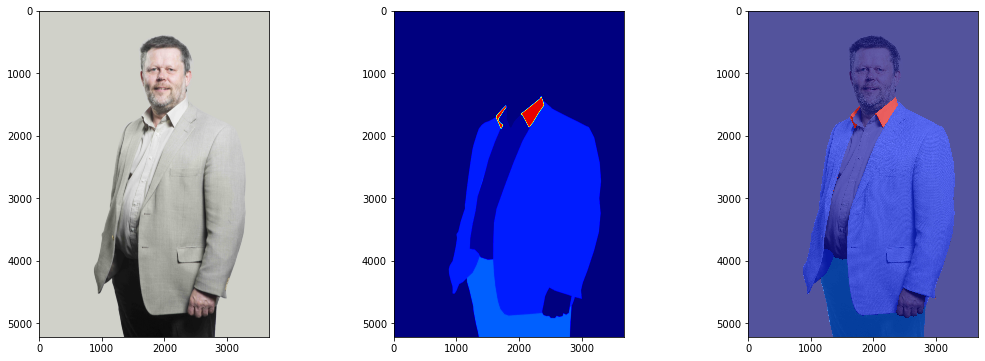

In [69]:
Masking_Image('00000663ed1ff0c4e0132b9b9ac53f6e.jpg')

Correct Category : [10, 33, 37]
Output : [-1, 10, 33, 37]


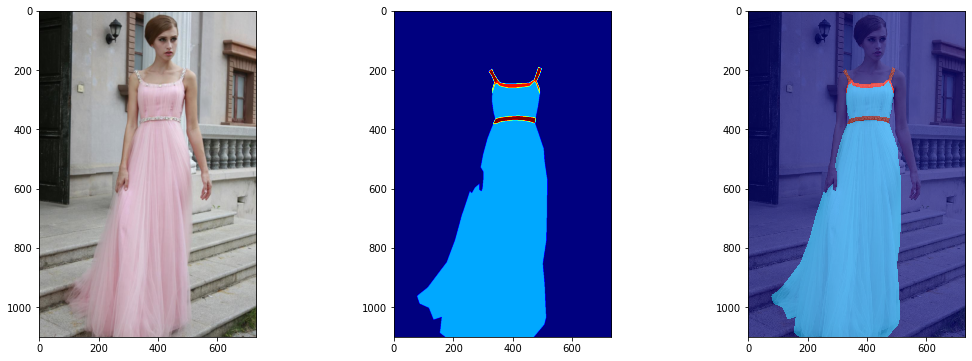

In [70]:
Masking_Image(train_df.iloc[132,0])

Correct Category : [10, 15, 23, 33]
Output : [-1, 10, 15, 23, 33]


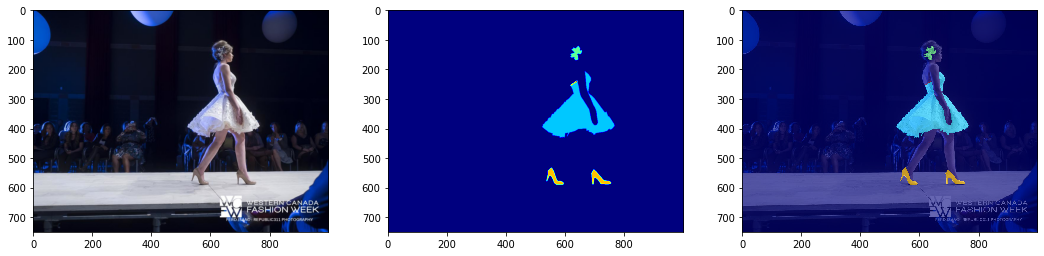

In [71]:
Masking_Image(train_df.iloc[2838,0])

Correct Category : [10, 23, 28, 31, 35]
Output : [-1, 10, 23, 28, 31, 35]


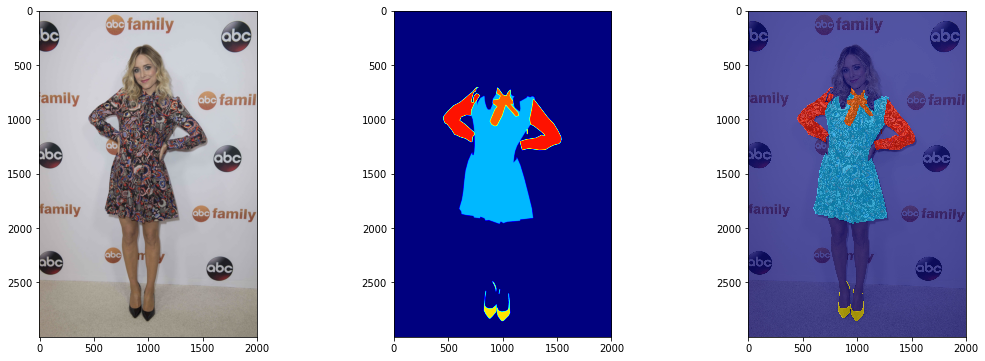

In [77]:
Masking_Image(train_df.iloc[156,0])